# Assignment 5

SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size
(https://arxiv.org/abs/1602.07360)

In this assigment you're going to use the pretrained network SqueezeNetv1.2 (~ 5 Mb) 

# Task 1 (5 points):

Go to https://github.com/miaow1988/SqueezeNet_v1.2 and download the 'symbol.json' and '.params' files (there is not a 'synset.txt' file! so don't use these lines, Hint: just comment these lines).

* Install MXNet v1.5 (hint: create a new conda environmet with python 3, pip install mxnet==1.5.1) and follow the same steps of the lecture (part: *Using pre-trained models as feature extractors*). Find the flatten output layer and create a feature extractor (hint: It should be a numpy array of 1000 elements).
* Download the dogs versus cats *training folder* from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data (Remember the number of images is 12500 for each class).
* Extract the array of features for different number of images (N: 10, 100, 500, 1000, also 5000 and 12500) and for each value train your favorite binary classifier (only one!!!) using GridSearch to optimize some hyperparameters. Consider to use https://notebooks.csc.fi if you have computational limitations. 

* Report the accuracy for each value of N and the computational time during the training step.



# Make sure to copy your kaggle.json token to the root folder of CSC

Install MXNet v1.5 (hint: create a new conda environmet with python 3, pip install mxnet==1.5.1) and follow the same steps of the lecture (part: Using pre-trained models as feature extractors). Find the flatten output layer and create a feature extractor (hint: It should be a numpy array of 1000 elements).

In [1]:
!pip install mxnet==1.5.1
!pip install art
!pip install opencv-python-headless

import mxnet as mx
mx.__version__

'1.5.1'

In [2]:
import mxnet as mx
# Download the pretrained network
path='https://github.com/miaow1988/SqueezeNet_v1.2/'
directory = './SqueezeNet_v1.2/'
[mx.test_utils.download(path+'raw/master/model-0000.params', dirname=directory),
 mx.test_utils.download(path+'raw/master/model-symbol.json', dirname=directory)]

['./SqueezeNet_v1.2/model-0000.params', './SqueezeNet_v1.2/model-symbol.json']

In [3]:
sym, arg_params, aux_params = mx.model.load_checkpoint("SqueezeNet_v1.2/model", 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

In [4]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['fire9_concat_output',
 'dropout0_output',
 'conv10_conv_weight',
 'conv10_conv_bias',
 'conv10_conv_output',
 'conv10_relu_output',
 'pool10_output',
 'flatten0_output',
 'softmax_label',
 'softmax_output']

In [5]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image. Remove query string from the file name.
    if url.startswith('http'):
        fname = mx.test_utils.download(url, fname=url.split('/')[-1].split('?')[0])
    else:
        fname = url
    img = mx.image.imread(fname)
    if img is None:
        return None
    if show:
        plt.imshow(img.asnumpy())
        plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = mx.image.imresize(img, 224, 224) # resize
    img = img.transpose((2, 0, 1)) # Channel first
    img = img.expand_dims(axis=0) # batchify
    img = img.astype('float32') # for gpu context
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([img]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))
        
def get_features(img):
    fe_mod.forward(Batch([mx.nd.array(img)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    return features        

In [7]:
img = get_image('https://github.com/dmlc/web-data/blob/master/mxnet/doc/tutorials/python/predict_image/cat.jpg?raw=true')
fe_mod.forward(Batch([img]))
features = fe_mod.get_outputs()[0]
print('Shape',features.shape)
print(features.asnumpy())
assert features.shape == (1, 1000)

Shape (1, 1000)
[[ 7.740564    9.480387    3.9907155   5.550856    7.4798946   8.9992075
   7.18169    13.219108   17.030085   19.92069    14.087179   14.110888
  11.295056   11.314932   13.278534    8.8031225  14.675961   17.594906
  10.547035    7.3058777   9.917198   16.946892   10.613432   13.36103
  11.913334    6.9719872  12.397531   12.817046    7.8395066   7.3672657
   6.2191815   9.127987    8.44347     5.85803     5.6687      9.273978
   8.574013    9.891539   13.275679    7.9678736  12.7983675   7.098754
  11.217385   14.532465   10.495641    5.708142   12.013867   11.896805
   6.9982615   7.134784    4.5558195   8.647603    6.5585046   5.2419167
   7.987683    4.515832    3.2960477   4.1781144   5.6512504   4.645506
   4.848237    7.1156077   7.929356    7.1285825   5.3620315   5.362695
  12.981428    6.515897    8.095128    5.671469    4.5027547   4.4114804
   5.565266    7.5312557   5.857764    4.9016113   6.294036    7.9544945
  12.700937    6.1515536  10.765704   10.154

Download the dogs versus cats training folder from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data (Remember the number of images is 12500 for each class).

In [8]:
! pip install -q kaggle
! rm -r ~/.kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Download and unzip data
from time import time
start = time()
! kaggle competitions download --quiet -c dogs-vs-cats-redux-kernels-edition;
! unzip -o dogs-vs-cats-redux-kernels-edition.zip;
! unzip -o -qq train.zip;
! unzip -o -qq test.zip;

print(f'\nRuntime {time()-start:.2f} sec')

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               

Runtime 46.50 sec


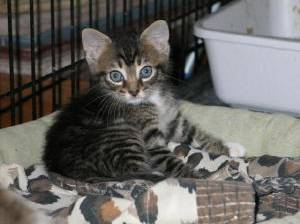

In [10]:
import os
from IPython.core.display import Image
display(Image(f'{os.getcwd()}/train/cat.12.jpg'))

In [11]:
import glob

train_items = glob.glob('./train/*.jpg')
print(f'N° of training images : {len(train_items)}')

test_items = glob.glob('./test/*.jpg')
print(f'N° of test images : {len(test_items)}')

train_cat_items = glob.glob('./train/cat*.jpg')
print(f'\nN° of training cat images : {len(train_cat_items)}')
train_dog_items = glob.glob('./train/dog*.jpg')
print(f'N° of training dog images : {len(train_dog_items)}')

N° of training images : 25000
N° of test images : 12500

N° of training cat images : 12500
N° of training dog images : 12500


In [12]:
from os import listdir
from os.path import isfile, join
import os

mypath = ('./train')

cats_imgs = [join(mypath,f) for f in listdir(mypath) if f.startswith('cat')]
dogs_imgs = [join(mypath,f) for f in listdir(mypath) if f.startswith('dog')]
print("cats: {} and dogs: {}".format(len(cats_imgs),len(dogs_imgs)))

cats: 12500 and dogs: 12500


In [13]:
import cv2
Nmax = 10
cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [14]:
Y_cats = np.array(Nmax * [1])
Y_dogs = np.array(Nmax * [0])

In [15]:
X_cvd = np.vstack([cats_features,dogs_features])
Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, shuffle=True, random_state=42)

In [17]:
from sklearn import svm

model = svm.SVC(probability=True).fit(X_train, y_train)

print("Test set score: {:.2f}".format(model.score(X_test, y_test)))

Test set score: 1.00


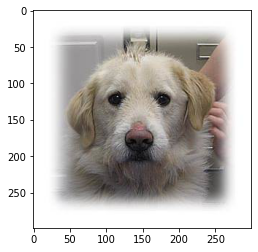

In [18]:
import matplotlib.image as mpimg

dog_test_path = './test/3.jpg'
cat_test_path = './test/103.jpg'

img = mpimg.imread(dog_test_path)
imgplot = plt.imshow(img)
plt.show()

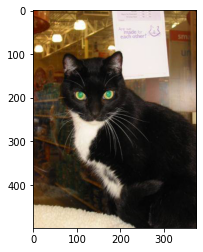

In [19]:
img = mpimg.imread(cat_test_path)
imgplot = plt.imshow(img)
plt.show()

In [20]:
features_out = get_features(get_image(cat_test_path))

prob = model.predict_proba(features_out)
pred = model.predict(features_out)

if pred[0] == 1:
    fpred = 'cat'
else:
    fpred = 'dog'
    
print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[0.24091832 0.75908168]] and prediction: cat


In [21]:
features_out = get_features(get_image(dog_test_path))

prob = model.predict_proba(features_out)
pred = model.predict(features_out)

if pred[0] == 1:
    fpred = 'cat'
else:
    fpred = 'dog'
    
print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[0.8448381 0.1551619]] and prediction: dog


Extract the array of features for different number of images (N: 10, 100, 500, 1000, also 5000 and 12500) and for each value train your favorite binary classifier (only one!!!) using GridSearch to optimize some hyperparameters. Consider to use https://notebooks.csc.fi if you have computational limitations.

In [22]:
from sklearn.model_selection import GridSearchCV

N = [10, 100, 500, 1000, 5000, 12500]
# Reduce execution time
N = [10, 100, 500, 1000]

for Nmax in N:
    print("** Using %d images **"%(Nmax))
    cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
    dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]
    Y_cats = np.array(Nmax * [1])
    Y_dogs = np.array(Nmax * [0])
    X_cvd = np.vstack([cats_features,dogs_features])
    Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()    
    X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)    
    model = svm.SVC(probability=True).fit(X_train, y_train)
    
    param_grid = {'C': [0.001, 0.01, 0.1, 1.0]}
    search = GridSearchCV(model, param_grid, n_jobs=-1)
    search.fit(X_train, y_train)
    print("Accuracy: %.2f\tFit time:%.2fs\tScore time:%.2fs\n"%(
        search.score(X_test, y_test),
        search.cv_results_['mean_fit_time'][search.best_index_],
        search.cv_results_['mean_score_time'][search.best_index_]
    ))    

** Using 10 images **
Accuracy: 1.00	Fit time:0.00s	Score time:0.00s

** Using 100 images **
Accuracy: 0.94	Fit time:0.06s	Score time:0.00s

** Using 500 images **
Accuracy: 0.94	Fit time:0.68s	Score time:0.03s

** Using 1000 images **
Accuracy: 0.95	Fit time:2.50s	Score time:0.10s



#### Task 2 (5 points):

Repeat all previous steps using MobileNet V2 (https://github.com/KeyKy/mobilenet-mxnet). How the two networks compare in terms of accuracy and running time?

**WARNING**: At least for N= 5000 and 12500 it can take some time in your computer, depending of your resources. The time can largely increases depending of your chosen classifier.

In [23]:
# Download the pretrained network
path='https://github.com/KeyKy/mobilenet-mxnet/'
directory = './mobilenet-mxnet/'
[mx.test_utils.download(path+'raw/master/mobilenet_v2-0000.params', dirname=directory, overwrite=True),
 mx.test_utils.download(path+'raw/master/mobilenet_v2-symbol.json', dirname=directory, overwrite=True)]

['./mobilenet-mxnet/mobilenet_v2-0000.params',
 './mobilenet-mxnet/mobilenet_v2-symbol.json']

In [24]:
sym, arg_params, aux_params = mx.model.load_checkpoint("mobilenet-mxnet/mobilenet_v2", 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

In [25]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['conv6_4_bn_moving_var',
 'conv6_4_bn_output',
 'relu6_4_output',
 'pool6_output',
 'fc7_weight',
 'fc7_bias',
 'fc7_output',
 'fc7_output',
 'prob_label',
 'prob_output']

In [26]:
fe_sym = sym.get_internals()[len(sym.get_internals().list_outputs())-3]
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [27]:
from sklearn.model_selection import GridSearchCV

N = [10, 100, 500, 1000, 5000, 12500]
# Reduce execution time
N = [10, 100, 500, 1000]

for Nmax in N:
    print("** Using %d images **"%(Nmax))
    cats_features = [get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
    dogs_features = [get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]
    Y_cats = np.array(Nmax * [1])
    Y_dogs = np.array(Nmax * [0])
    X_cvd = np.vstack([cats_features,dogs_features])
    Y_cvd = np.vstack([Y_cats,Y_dogs]).ravel()    
    X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, random_state=42)    
    model = svm.SVC(probability=True).fit(X_train, y_train)
    
    param_grid = {'C': [0.001, 0.01, 0.1, 1.0]}
    search = GridSearchCV(model, param_grid, n_jobs=-1)
    search.fit(X_train, y_train)
    print("Accuracy: %.2f\tFit time:%.2fs\tScore time:%.2fs\n"%(
        search.score(X_test, y_test),
        search.cv_results_['mean_fit_time'][search.best_index_],
        search.cv_results_['mean_score_time'][search.best_index_]
    ))       

** Using 10 images **
Accuracy: 0.40	Fit time:0.00s	Score time:0.00s

** Using 100 images **
Accuracy: 0.48	Fit time:0.10s	Score time:0.01s

** Using 500 images **
Accuracy: 0.57	Fit time:2.06s	Score time:0.11s

** Using 1000 images **
Accuracy: 0.57	Fit time:8.75s	Score time:0.42s



#### Task 3 (5 points):

Using the best network. Train a machine learning model able to predic COVID-19 from chest X-Ray images. Use the data from https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset. 

Present and discuss your best model.

In [28]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset")

Skipping, found downloaded files in "./coronahack-chest-xraydataset" (use force=True to force download)


In [41]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [42]:
data_path = './coronahack-chest-xraydataset/'
img_path = data_path + 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset'
train_img_dir = img_path + '/train'
test_img_dir = img_path + '/test'
img_dir = os.listdir(img_path)
df_meta = pd.read_csv(data_path+'Chest_xray_Corona_Metadata.csv')
df_meta_summary = pd.read_csv(data_path+'Chest_xray_Corona_dataset_Summary.csv')

In [43]:
df_meta.tail()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus
5909,5932,person1632_virus_2827.jpeg,Pnemonia,TEST,NaN,Virus


In [44]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


In [45]:
#replace null data points to 'unknown'
df_meta.fillna('unknown', inplace=True)
df_meta.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

In [46]:
print((df_meta['Label_1_Virus_category']).value_counts())
print((df_meta['Label_2_Virus_category']).value_counts())

bacteria          2777
unknown           1576
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64
unknown          5841
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64


In [47]:
train_data = df_meta[df_meta['Dataset_type']=='TRAIN']
test_data = df_meta[df_meta['Dataset_type']=='TEST']
assert train_data.shape[0] + test_data.shape[0] == df_meta.shape[0]
print(f"Shape of train data: {train_data.shape}")
print(f"Shape of test data: {test_data.shape}")
train_data.sample(5)

Shape of train data: (5286, 6)
Shape of test data: (624, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
4171,4171,person59_bacteria_279.jpeg,Pnemonia,TRAIN,unknown,bacteria
2989,2989,person23_bacteria_99.jpeg,Pnemonia,TRAIN,unknown,bacteria
1849,1849,person1163_virus_1951.jpeg,Pnemonia,TRAIN,unknown,Virus
3045,3045,person1938_bacteria_4854.jpeg,Pnemonia,TRAIN,unknown,bacteria
5285,5308,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,Pnemonia,TRAIN,COVID-19,Virus


In [48]:
test_data.sample(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5444,5467,NORMAL2-IM-0221-0001.jpeg,Normal,TEST,unknown,unknown
5584,5607,person142_bacteria_682.jpeg,Pnemonia,TEST,unknown,bacteria
5463,5486,NORMAL2-IM-0139-0001.jpeg,Normal,TEST,unknown,unknown
5888,5911,person1659_virus_2867.jpeg,Pnemonia,TEST,unknown,Virus
5505,5528,NORMAL2-IM-0353-0001.jpeg,Normal,TEST,unknown,unknown


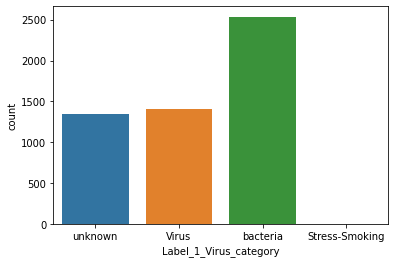

In [49]:
sns.countplot(train_data['Label_1_Virus_category'])

In [50]:
train_data.loc[train_data['Label'].eq('Normal'), 'class'] = 'NO_COVID';
train_data.loc[(train_data['class'].ne('healthy') & train_data['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'NO_COVID';
train_data.loc[(train_data['class'].ne('healthy') & train_data['class'].ne('bacteria') & train_data['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';
train_data.loc[(train_data['class'].ne('healthy') & train_data['class'].ne('bacteria') & train_data['class'].ne('COVID-19')), 'class'] = 'NO_COVID';

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [51]:
target_dict = {
               'NO_COVID' : 0,
               'COVID-19' : 1
              }
train_data['target'] = train_data['class'].map(target_dict);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


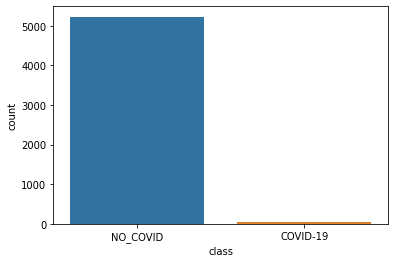

In [52]:
sns.countplot(train_data['class']);

In [53]:
train_data.loc[train_data['class'] == 'NO_COVID', "X_ray_image_name"]

0                                       IM-0128-0001.jpeg
1                                       IM-0127-0001.jpeg
2                                       IM-0125-0001.jpeg
3                                       IM-0122-0001.jpeg
4                                       IM-0119-0001.jpeg
                              ...                        
5233    SARS-10.1148rg.242035193-g04mr34g09c-Fig9c-day...
5234    SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day...
5235    SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day...
5236    SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day...
5241            F051E018-DAD1-4506-AD43-BE4CA29E960B.jpeg
Name: X_ray_image_name, Length: 5228, dtype: object

In [54]:
import pandas as pd
train_df = pd.read_csv('./coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')
valid_df = pd.read_csv('./coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv')

print('The training dataset has rows : ', format(train_df.shape[0]))
print('The training dataset has cols : ', format(train_df.shape[1]))

The training dataset has rows :  5910
The training dataset has cols :  6


In [55]:
train_df.head(5)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [56]:
sym, arg_params, aux_params = mx.model.load_checkpoint("SqueezeNet_v1.2/model", 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image. Remove query string from the file name.
    if url.startswith('http'):
        fname = mx.test_utils.download(url, fname=url.split('/')[-1].split('?')[0])
    else:
        fname = url
    img = mx.image.imread(fname)
    if img is None:
        return None
    if show:
        plt.imshow(img.asnumpy())
        plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = mx.image.imresize(img, 224, 224) # resize
    img = img.transpose((2, 0, 1)) # Channel first
    img = img.expand_dims(axis=0) # batchify
    img = img.astype('float32') # for gpu context
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([img]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))
        
def get_features(img):
    fe_mod.forward(Batch([mx.nd.array(img)]))
    features = fe_mod.get_outputs()[0].asnumpy()
    return features        

./coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset


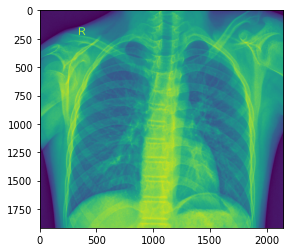

In [58]:
import matplotlib.image as mpimg
print(img_path)
test_path = img_path + '/test/IM-0011-0001-0001.jpeg'
img = mpimg.imread(test_path)
imgplot = plt.imshow(img)
plt.show()

In [59]:
from os import listdir
from os.path import isfile, join
import os

mypath = (img_path + '/train/')
print(mypath)
nocovid_images = train_data.loc[train_data['class'] == 'NO_COVID', "X_ray_image_name"]
covid_images = train_data.loc[train_data['class'] == 'COVID-19', "X_ray_image_name"]

print("COVID: {} and NO_COVID: {}".format(len(covid_images),len(nocovid_images)))

./coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/
COVID: 58 and NO_COVID: 5228


In [60]:
nocovid_images = mypath + nocovid_images
covid_images = mypath + covid_images

In [61]:
print(nocovid_images.tail())

5233    ./coronahack-chest-xraydataset/Coronahack-Ches...
5234    ./coronahack-chest-xraydataset/Coronahack-Ches...
5235    ./coronahack-chest-xraydataset/Coronahack-Ches...
5236    ./coronahack-chest-xraydataset/Coronahack-Ches...
5241    ./coronahack-chest-xraydataset/Coronahack-Ches...
Name: X_ray_image_name, dtype: object


In [62]:
import cv2
Nmax = 10

covid_features = [get_features(get_image(img)).ravel() for img in covid_images[:Nmax]]
nocovid_features = [get_features(get_image(img)).ravel() for img in nocovid_images[:Nmax]]

In [63]:
Y_covid = np.array(Nmax * [1])
Y_nocovid = np.array(Nmax * [0])

In [64]:
X_cvd = np.vstack([covid_features,nocovid_features])
Y_cvd = np.vstack([Y_covid,Y_nocovid]).ravel()

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cvd, Y_cvd, shuffle=True, random_state=42)

In [66]:
from sklearn import svm

model = svm.SVC(probability=True).fit(X_train, y_train)

print("Test set score: {:.2f}".format(model.score(X_test, y_test)))

Test set score: 0.80


In [67]:
features_out = get_features(get_image(test_path))

prob = model.predict_proba(features_out)
pred = model.predict(features_out)

if pred[0] == 1:
    fpred = 'Virus'
else:
    fpred = 'Normal'
    
print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[0.76589378 0.23410622]] and prediction: Normal


In [68]:
from art import tprint, aprint
tprint('See  you  soon!')

 ____                                                                  _ 
/ ___|   ___   ___    _   _   ___   _   _    ___   ___    ___   _ __  | |
\___ \  / _ \ / _ \  | | | | / _ \ | | | |  / __| / _ \  / _ \ | '_ \ | |
 ___) ||  __/|  __/  | |_| || (_) || |_| |  \__ \| (_) || (_) || | | ||_|
|____/  \___| \___|   \__, | \___/  \__,_|  |___/ \___/  \___/ |_| |_|(_)
                      |___/                                              

